Number of vertical areas:4
Height of areas:3.0
Number of horizontal areas:6
Width of the last area:3.6923076923076925
Width of other areas:2.4615384615384617
Number of snake steps:13
Snake step:0.6153846153846154
[(0.0, 0.7), (0.6153846153846154, 0.7), (0.6153846153846154, 2.3), (1.8461538461538463, 2.3), (1.8461538461538463, 0.7), (2.4615384615384617, 0.7), (2.4615384615384617, 0.7), (3.076923076923077, 0.7), (3.076923076923077, 2.3), (4.307692307692308, 2.3), (4.307692307692308, 0.7), (4.923076923076923, 0.7), (4.923076923076923, 0.7), (5.538461538461538, 0.7), (5.538461538461538, 2.3), (6.76923076923077, 2.3), (6.76923076923077, 0.7), (7.384615384615385, 0.7), (7.384615384615385, 0.7), (8.0, 0.7), (8.0, 2.3), (9.230769230769232, 2.3), (9.230769230769232, 0.7), (9.846153846153847, 0.7), (9.846153846153847, 0.7), (10.461538461538462, 0.7), (10.461538461538462, 2.3), (11.692307692307693, 2.3), (11.692307692307693, 0.7), (12.307692307692308, 0.7), (12.307692307692308, 0.7), (12.92307692

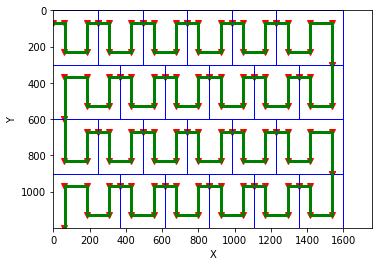

In [41]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import cv2

def map_exit2enter_point(exit_point,height,width,width_prev,camera_wr,snake_step):
  if exit_point == (width_prev,camera_wr):
    return (0,camera_wr)
  if exit_point == (width_prev - snake_step,height):
    return (width - snake_step,0)
  if exit_point == (0,camera_wr):
    return (width,camera_wr)
  if exit_point == (snake_step,height):
    return (snake_step,0)
  


class area:
  def __init__(self,x,y,height,width,width_prev,enter_point,snake_step,camera_wr,is_last = False):
    self.x = x
    self.y = y
    self.height = height
    self.width = width
    self.border_corners = [(x,y),(x+width,y),(x+width,y+height),(x,y+height)]
    self.width_prev = width_prev
    self.enter_point = enter_point
    self.snake_step = snake_step
    self.camera_wr = camera_wr
    self.is_last = is_last
    self.enter_point = enter_point
    if enter_point[0] == 0 and enter_point[1] == camera_wr:
      if is_last:
        exit_point = (width - snake_step , height)
      else:
        exit_point = (width , camera_wr)
    if enter_point[0] == width - snake_step and enter_point[1] == 0:
      if self.is_last:
        exit_point = (self.snake_step,self.height)
      else:
        exit_point = (0 , camera_wr)
    if enter_point[0] == width and enter_point[1] == camera_wr:
      if is_last:
        exit_point = (snake_step , height)
      else:
        exit_point = (0 , camera_wr)
    if enter_point[0] == snake_step and enter_point[1] == 0:
      exit_point = (width , camera_wr)
    self.exit_point = exit_point
    self.internal_route_points = self.get_route()
    self.external_route_points = [(point[0] + self.x , point[1] + self.y)for point in self.internal_route_points]
    
  def get_route(self):
    if self.enter_point[0] == 0 and self.enter_point[1] == self.camera_wr:
      if self.is_last:
        return [self.enter_point,(self.snake_step,self.camera_wr),(self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.camera_wr),(self.width - self.snake_step,self.camera_wr),self.exit_point]
      else:
        return [self.enter_point,(self.snake_step,self.camera_wr),(self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.camera_wr),self.exit_point]
    if self.enter_point[0] == self.width - self.snake_step and self.enter_point[1] == 0:
      if self.is_last:
        return [self.enter_point,(self.width - self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.camera_wr),(self.snake_step,self.camera_wr),self.exit_point]
      else:
        return [self.enter_point,(self.width - self.snake_step,self.height - self.camera_wr),(self.snake_step,self.height - self.camera_wr),(self.snake_step,self.camera_wr),self.exit_point]
    if self.enter_point[0] == self.width and self.enter_point[1] == self.camera_wr:
      if self.is_last:
        return [self.enter_point,(self.width - self.snake_step,self.camera_wr),(self.width - self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.camera_wr),(self.snake_step,self.camera_wr),self.exit_point]
      else:
        return [self.enter_point,(self.width - self.snake_step,self.camera_wr),(self.width - self.snake_step,self.height - self.camera_wr),(self.snake_step,self.height - self.camera_wr),(self.snake_step,self.camera_wr),self.exit_point]
    if self.enter_point[0] == self.snake_step and self.enter_point[1] == 0:
      return [self.enter_point,(self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.height - self.camera_wr),(3*self.snake_step,self.camera_wr),self.exit_point]



wr = 0.7

H = 12

W = 16

if H < 4*wr or W < 6*wr:
  print(f'Too small terrain to clean')
  sys.exit()

Nh = int(H//(4*wr)) # number of vertical areas
hs = 4*wr + (H%(4*wr))/Nh # height of areas
if 8*wr < hs:
  print(f'Wrong height of areas:{hs}')
  sys.exit()

 # number of descents and ascents
nw = int(W//(2*wr))
if round(W%(2*wr),4) > 0:
  if nw%2 == 0:
    nw += 1
  if nw%2 == 1:
    nw += 2
  else:
    if nw%2 == 0:
      nw += 1
Nw = int((nw - 3)/2 + 1) # number of horizontal areas
dw = W/(2*nw)
wse = 6*dw
wsf = None  
if Nw > 1:
  wsf = 4*dw

print(f'Number of vertical areas:{Nh}\nHeight of areas:{hs}\nNumber of horizontal areas:{Nw}\n\
Width of the last area:{wse}\nWidth of other areas:{wsf}\nNumber of snake steps:{nw}\nSnake step:{dw}')

width_prev = wse

exit_point = (wse,wr)

areas = []

for h in range(Nh):
  areas_raw = []
  if Nw == 1:
    areas_raw.append(area(0,h * hs,hs,wse,width_prev,map_exit2enter_point(exit_point,hs,wse,width_prev,wr,dw),dw,wr,True))
    width_prev = areas_raw[-1].width
    exit_point = areas_raw[-1].exit_point
  else:
    if h%2 == 0:
      idx_iter = range(Nw)
      end_area_idx = Nw - 1
    else:
      idx_iter = reversed(range(Nw))
      end_area_idx = 0
    for v in idx_iter:
      if v == end_area_idx:
          areas_raw.append(area(v * wsf,h * hs,hs,wse,width_prev,map_exit2enter_point(exit_point,hs,wse,width_prev,wr,dw),dw,wr,True))
          width_prev = areas_raw[-1].width
          exit_point = areas_raw[-1].exit_point
      else:
        if h%2 == 0:
          areas_raw.append(area(v * wsf,h * hs,hs,wsf,width_prev,map_exit2enter_point(exit_point,hs,wsf,width_prev,wr,dw),dw,wr,False))
          width_prev = areas_raw[-1].width
          exit_point = areas_raw[-1].exit_point
        else:
          areas_raw.append(area((v-1) * wsf + wse,h * hs,hs,wsf,width_prev,map_exit2enter_point(exit_point,hs,wsf,width_prev,wr,dw),dw,wr,False))
          width_prev = areas_raw[-1].width
          exit_point = areas_raw[-1].exit_point
  areas.append(areas_raw)
'''
for raw_idx,raw in enumerate(areas):
  if raw_idx%2 == 1:
    areas[raw_idx] = reversed(raw)
'''

route_points = []
areas_corners = []
for areas_r  in areas:
  for area in areas_r:
    areas_corners.append(area.border_corners)
    for point in area.external_route_points:
      route_points.append(point)

print(route_points)

mask = np.ones((int(H * 100),int(W * 110),3),dtype = np.uint)*255

for p in route_points:
  plt.plot(int(p[0] * 100), int(p[1] * 100), marker='v', color="red")
for area_crns in areas_corners:
  for c_idx in range(len(area_crns)-1):
    plt.plot([int(area_crns[c_idx][0] * 100),int(area_crns[c_idx+1][0] * 100)],[int(area_crns[c_idx][1] * 100),int(area_crns[c_idx+1][1] * 100)], color="blue", linewidth=1)

for i in range(len(route_points)-1):
  plt.plot([route_points[i][0]*100,route_points[i+1][0]*100],[route_points[i][1]*100,route_points[i+1][1]*100], color="green", linewidth=3)
plt.xlabel('X')
plt.ylabel('Y')
plt.imshow(mask)
